## Importing Libraries


In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

## Data Preperation
 
1.   Load all training and testing data

2.   Pre-processing images (apply opencv functions : bilateralFilter,applyColorMap,resize)

3.   Append images and labels into Python list

4.   Convert lists into numpy array and normalize images with devide by 255

5.   One Hot Encoding on the labels

6.   Dividing the dataset into Training and Validation sets





In [2]:


labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('C:/Users/emre_/jupyter/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('C:/Users/emre_/jupyter/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:02<00:00, 117.74it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


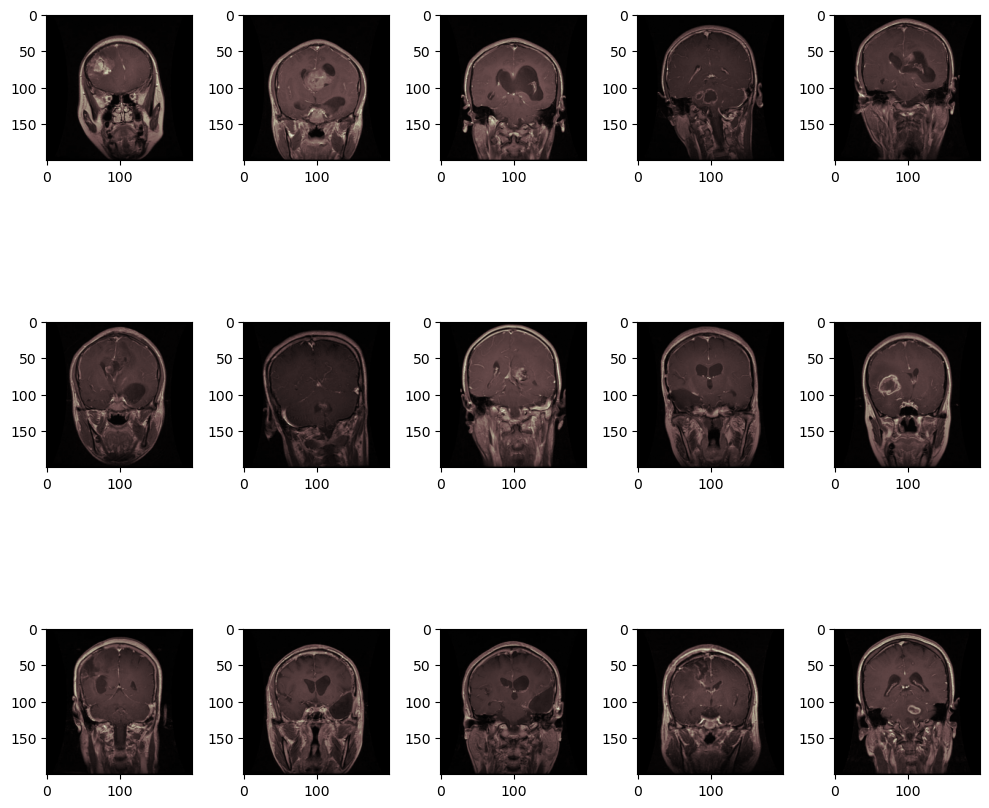

In [3]:

images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [4]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


## Data Augmentation
In order to make the most of our few training examples, we will **augment** them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent **overfitting** and helps the model generalize better.

In [5]:

# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

## Pre-trained Model
Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.


In this project, I'll be using the **ResNet50** model which will use the weights from the **ImageNet** dataset.




**Note**

Setting `include_top` to `False` moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training



In [7]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while pooling. This really helps in decreasing the computational load on the machine while training.

**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The rate parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the softmax function which is a generalization of the sigmoid function.

In [8]:

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

## Log confusion matrix to TensorBoard

With the following code you can log the confusion matrix for all epochs.

In [19]:
%load_ext tensorboard


class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

# Following function will make predictions from the model and log the confusion matrix as an image. 
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Remove previous log folder
!rm -fr logs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Run tensorBoard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 25448), started 7 days, 7:42:09 ago. (Use '!kill 25448' to kill it.)

## Training
**callback** -> set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

**LambdaCallback** ->  will log the confusion matrix on every epoch.

**ModelCheckpoint** -> callback to save the Keras model or model weights at some frequency.

**EarlyStopping** -> stop training when a monitored metric has stopped improving.

**ReduceLROnPlateau** -> reduce learning rate when a metric has stopped improving.

In [10]:

#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)


Epoch 1/50


229/229 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.8947
Epoch 1: val_loss improved from inf to 3.25721, saving model to model-01-0.24-3.26.h5


C:\Users\emre_\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 193s 808ms/step - loss: 0.2936 - accuracy: 0.8947 - val_loss: 3.2572 - val_accuracy: 0.2450 - lr: 1.0000e-04
Epoch 2/50
229/229 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9615
Epoch 2: val_loss improved from 3.25721 to 2.53993, saving model to model-02-0.29-2.54.h5


C:\Users\emre_\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 213s 933ms/step - loss: 0.1196 - accuracy: 0.9615 - val_loss: 2.5399 - val_accuracy: 0.2931 - lr: 1.0000e-04
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9766
Epoch 3: val_loss improved from 2.53993 to 1.02145, saving model to model-03-0.59-1.02.h5


C:\Users\emre_\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 197s 862ms/step - loss: 0.0754 - accuracy: 0.9766 - val_loss: 1.0215 - val_accuracy: 0.5914 - lr: 1.0000e-04
Epoch 4/50
229/229 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9807
Epoch 4: val_loss improved from 1.02145 to 0.48325, saving model to model-04-0.82-0.48.h5


C:\Users\emre_\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 225s 982ms/step - loss: 0.0592 - accuracy: 0.9807 - val_loss: 0.4833 - val_accuracy: 0.8215 - lr: 1.0000e-04
Epoch 5/50
229/229 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9772
Epoch 5: val_loss improved from 0.48325 to 0.12963, saving model to model-05-0.96-0.13.h5


C:\Users\emre_\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/229 [==============================] - 199s 867ms/step - loss: 0.0703 - accuracy: 0.9772 - val_loss: 0.1296 - val_accuracy: 0.9633 - lr: 1.0000e-04
Epoch 6/50
229/229 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9851
Epoch 6: val_loss did not improve from 0.12963
229/229 [==============================] - 196s 857ms/step - loss: 0.0432 - accuracy: 0.9851 - val_loss: 0.1420 - val_accuracy: 0.9606 - lr: 1.0000e-04
Epoch 7/50
229/229 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9827
Epoch 7: val_loss did not improve from 0.12963
229/229 [==============================] - 199s 871ms/step - loss: 0.0549 - accuracy: 0.9827 - val_loss: 0.1934 - val_accuracy: 0.9580 - lr: 1.0000e-04
Epoch 8/50
229/229 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9908
Epoch 8: val_loss did not improve from 0.12963
229/229 [==============================] - 306s 1s/step - loss: 0.0276 - accuracy: 0.9908 - val_loss: 0.1365 - val_

## Learning curves

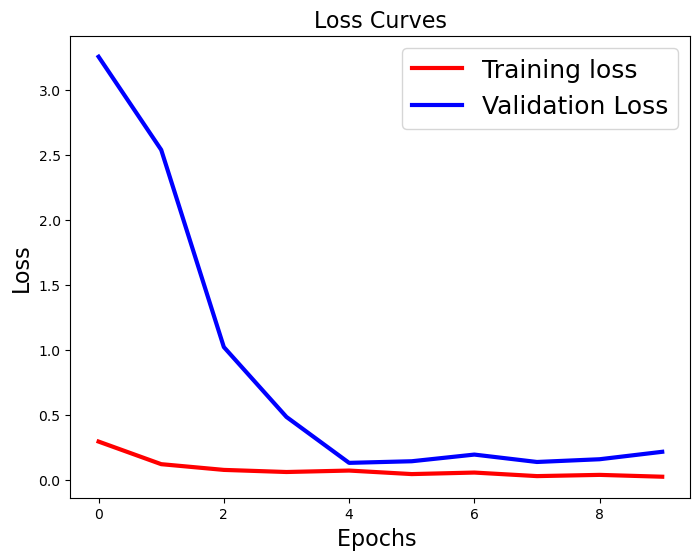

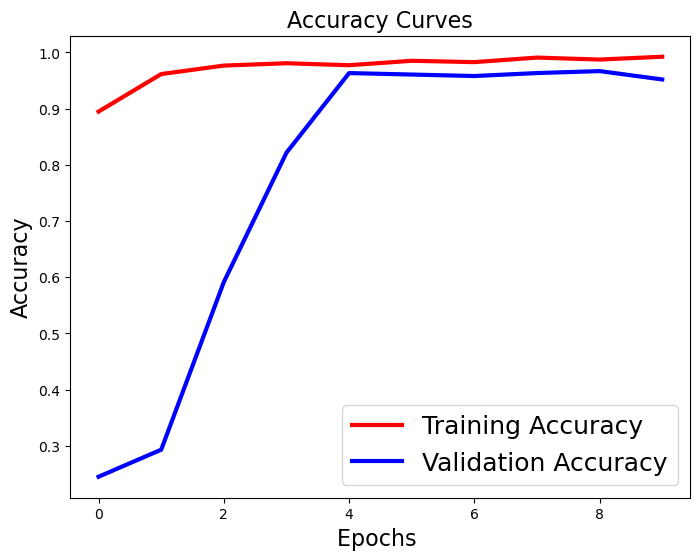

In [12]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation

41/41 [==============================] - 22s 548ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       300
           1       0.96      0.94      0.95       306
           2       1.00      0.99      0.99       405
           3       0.96      0.99      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



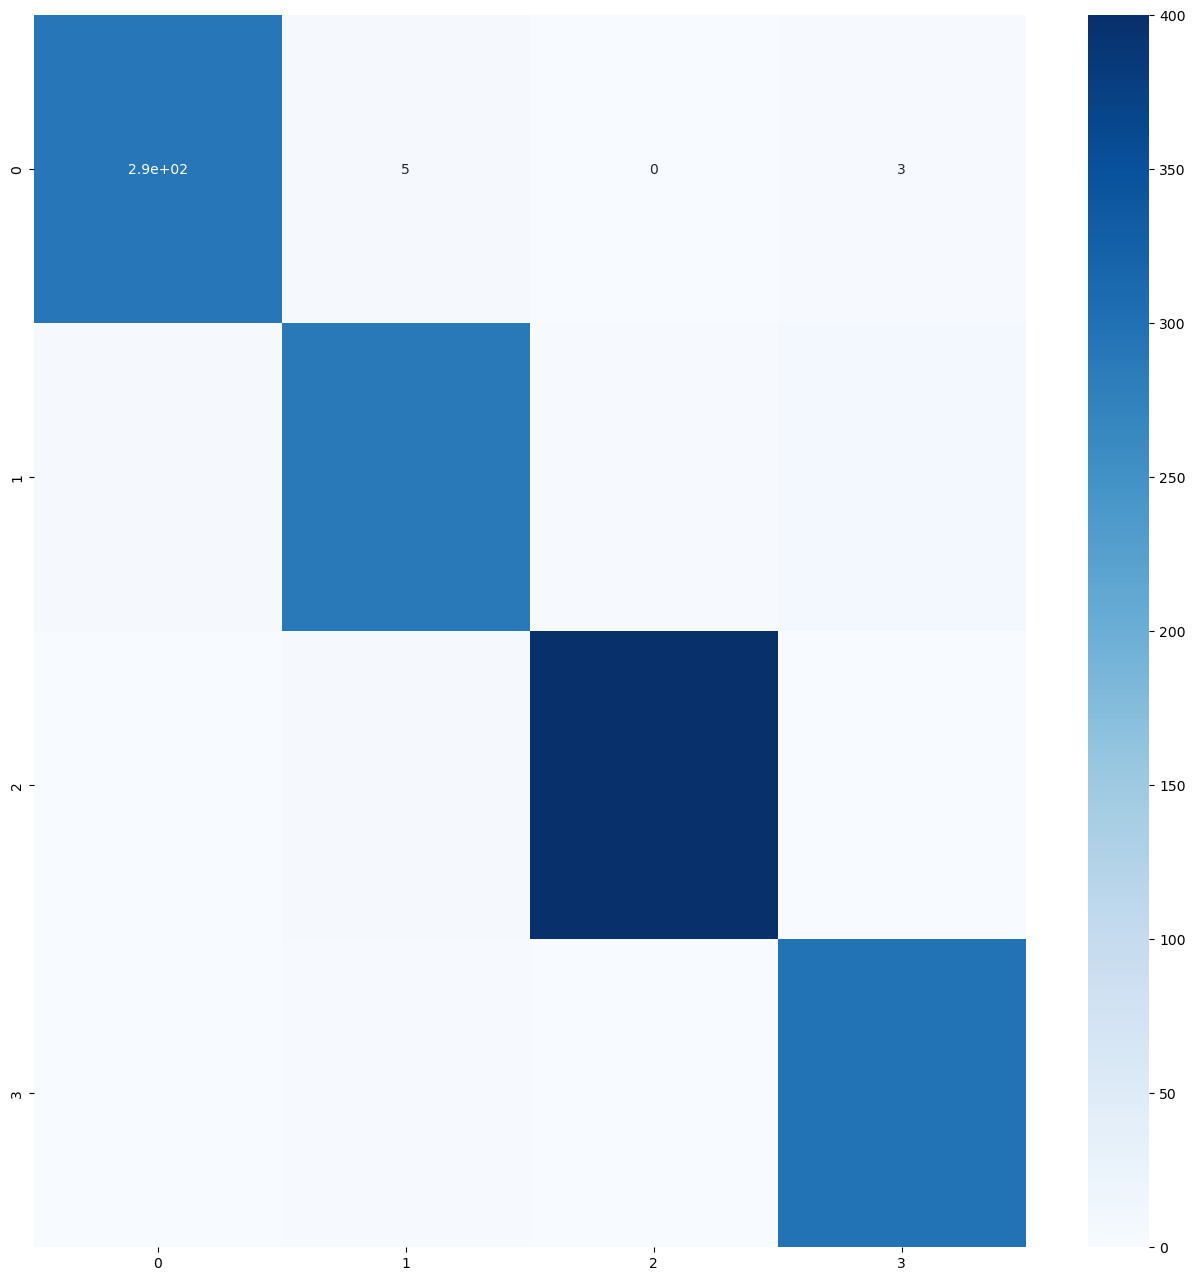

In [13]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [14]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 22s 529ms/step - loss: 0.1117 - accuracy: 0.9748


In [15]:
predicted_classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [16]:
np.argmax(y_test,axis=1)

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [17]:
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

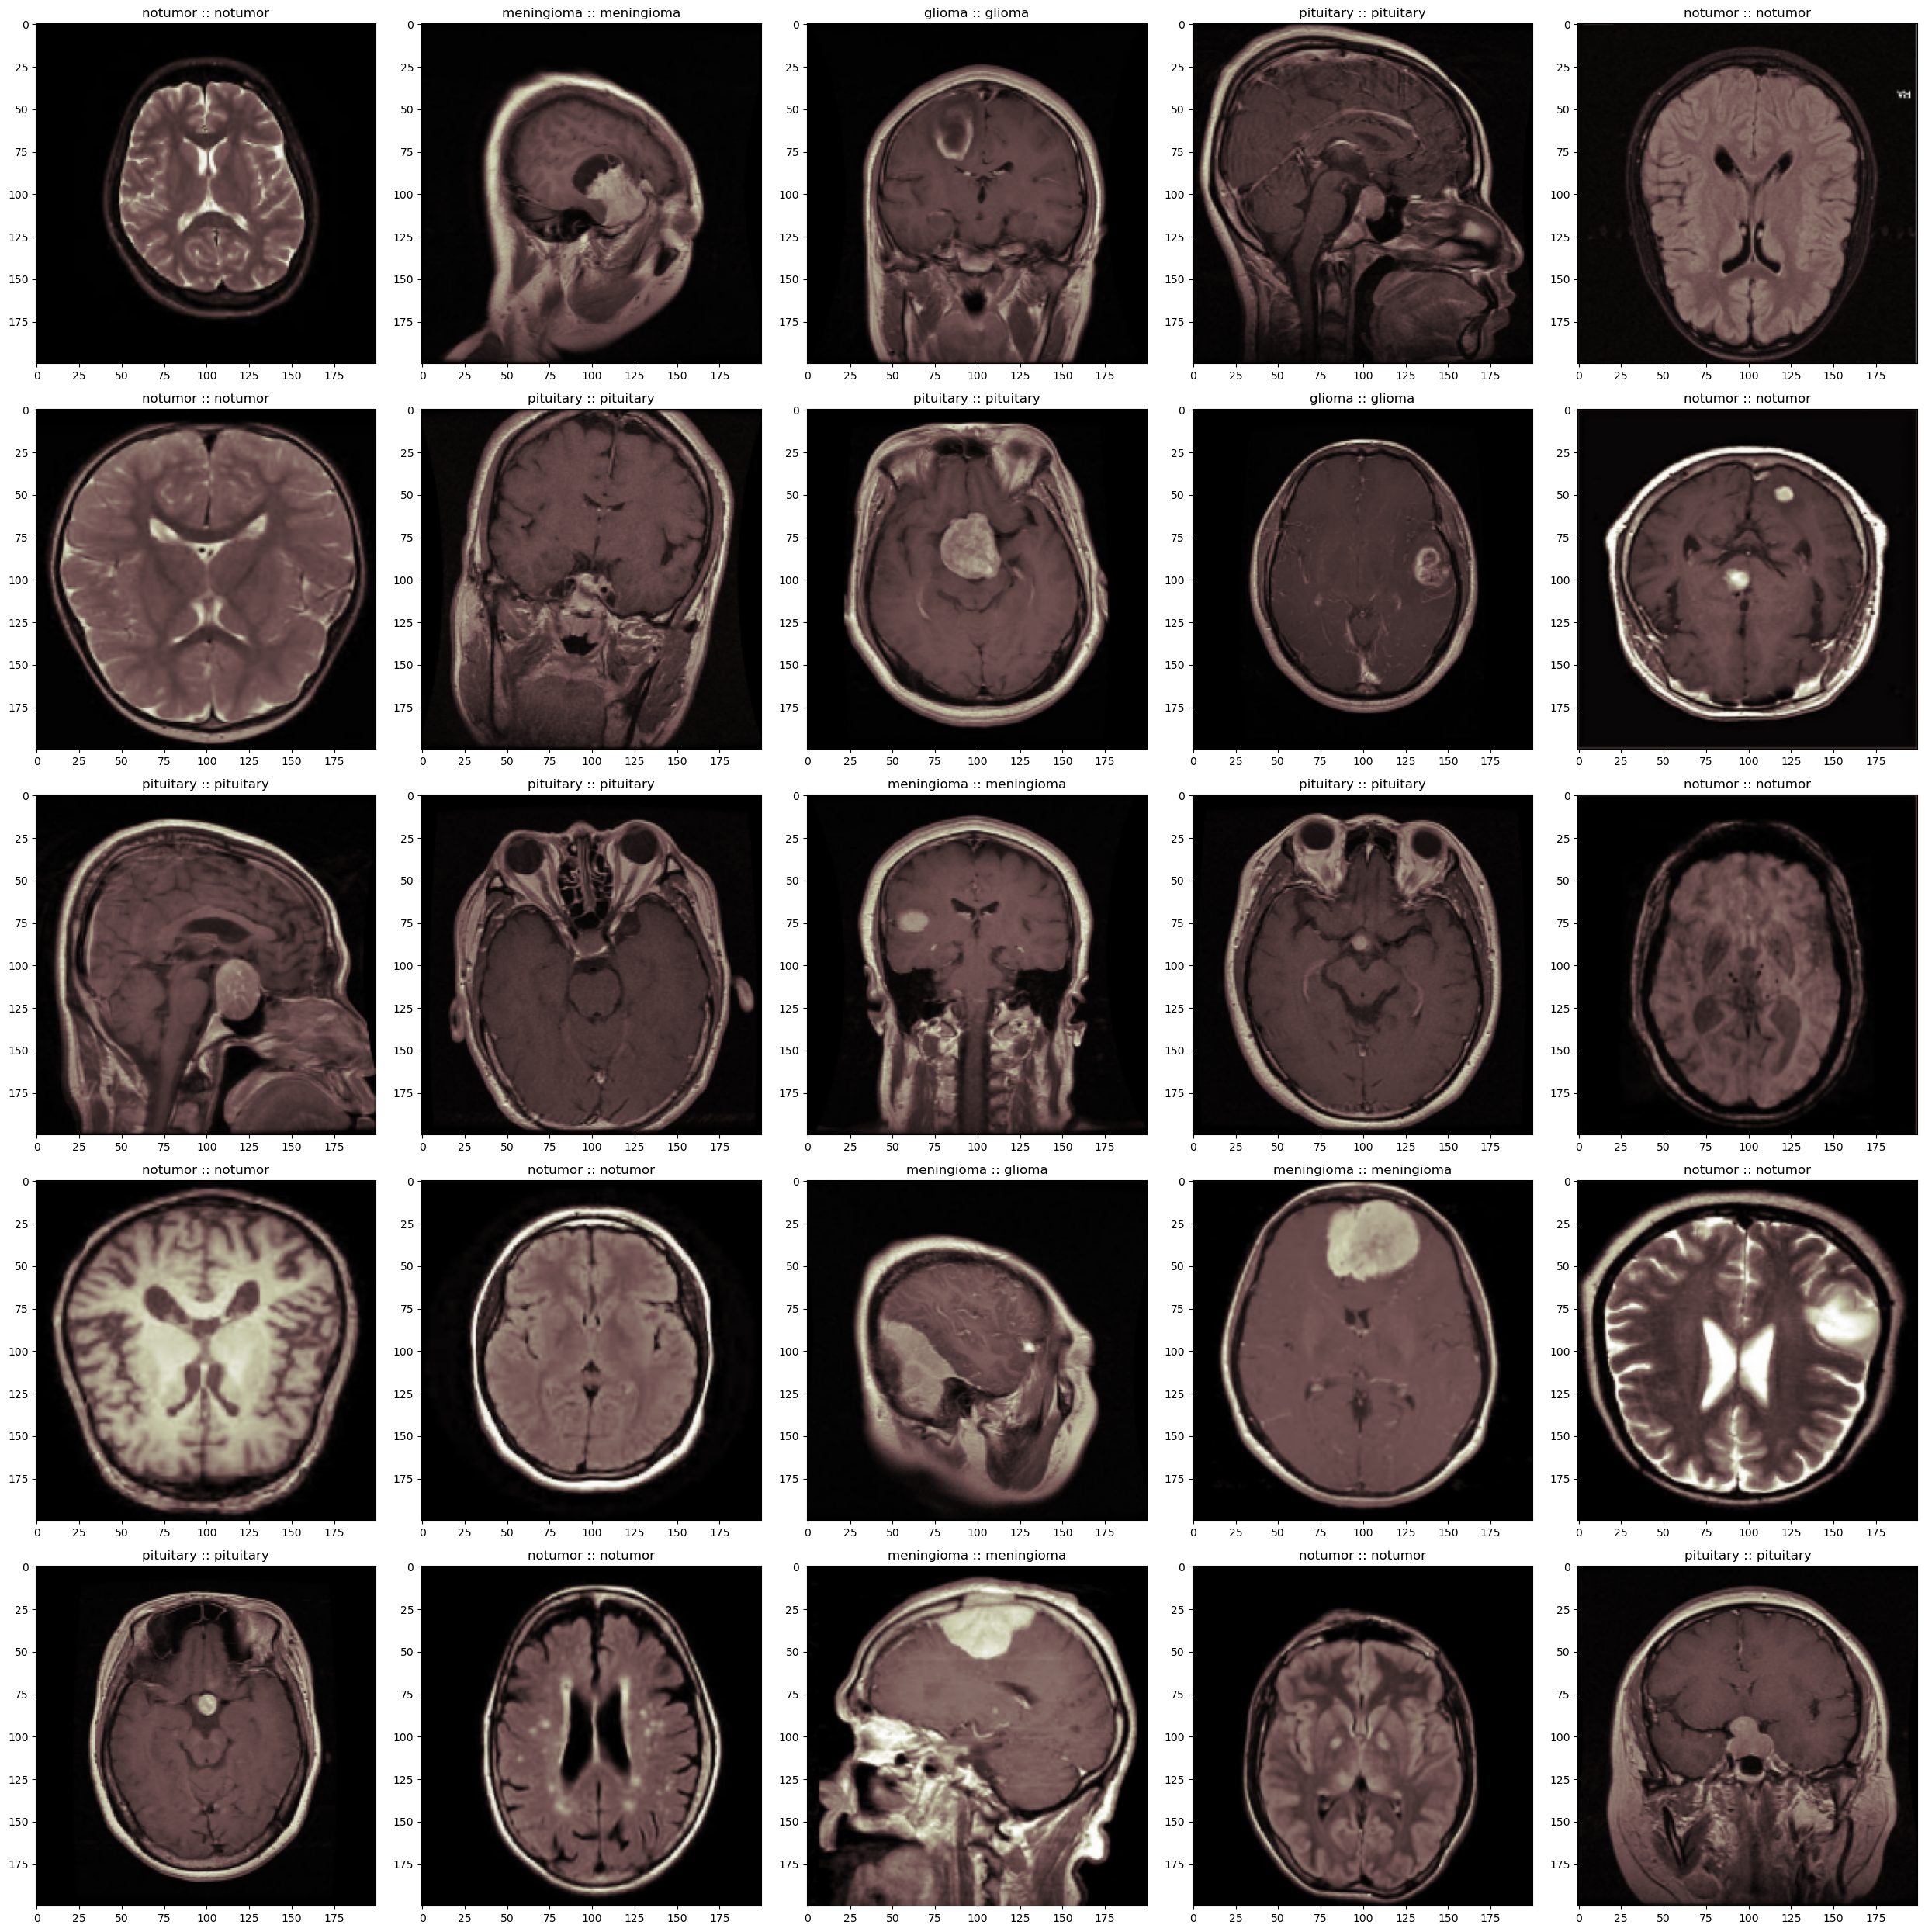

[824, 516, 241, 1125, 853, 836, 1084, 1175, 286, 834, 1104, 1076, 490, 1166, 666, 767, 774, 549, 327, 893, 1165, 941, 343, 678, 1118, 132, 172, 525, 1157, 1282, 729, 81]


In [18]:
import random

num_plots = 32
random_indices = random.sample(range(1310), num_plots)

images = [x_test[i] for i in random_indices]
fig, axes = plt.subplots(5, 5, figsize = (25, 25))
axes = axes.flatten()
a=0
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.set_title(f'{class_names[np.argmax(y_test,axis=1)[random_indices[a]]]} :: {class_names[predicted_classes[random_indices[a]]]}')
    a=a+1
plt.tight_layout()
plt.show()

print(random_indices)

In [17]:
import shutil
import zipfile
import os
import torch
import urllib.request
from IPython.display import Image, display

In [18]:
if os.path.exists('sample_data'):
  shutil.rmtree('sample_data')

In [19]:
# Clone YOLOv5 Repository
if os.path.exists('yolov5'):
  shutil.rmtree('yolov5/runs')
else:
  !git clone https://github.com/ultralytics/yolov5 
  %cd yolov5
  %pip install -r requirements.txt
  %cd ..

In [20]:
# Download and unzip the dataset

if not os.path.isfile('data.zip'):
  urllib.request.urlretrieve("https://github.com/giuseppebrb/BrainTumorDetection/blob/main/data.zip?raw=true", "data.zip")

with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

os.remove('data.zip')

In [21]:
# Folder for fine-tuned models
output_folder = 'output_models'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
else :
  os.makedirs(output_folder)

In [22]:
#  Check if cuda available / mps available / only CPU
if torch.cuda.is_available():
  device = 0
else:
  device = 'cpu'

In [23]:
# Training axial plane
!python yolov5/train.py --img 480 --batch 64 --epochs 400 --data ./data/axial/axial.yaml --weights yolov5m.pt --device {device} --name axial --hyp ./data/augmentation.yaml

# Copy the fine-tuned model inside the output folder
shutil.copyfile('yolov5/runs/train/axial/weights/best.pt', f'{output_folder}/tumor_detector_axial.pt')

^C


FileNotFoundError: [Errno 2] No such file or directory: 'yolov5/runs/train/axial/weights/best.pt'

In [ ]:
display(Image(filename='yolov5/runs/train/axial/F1_curve.png'))

In [ ]:
display(Image(filename='yolov5/runs/train/axial/PR_curve.png'))

In [ ]:
display(Image(filename='yolov5/runs/train/axial/confusion_matrix.png'))

In [ ]:
display(Image(filename='yolov5/runs/train/axial/results.png'))

In [ ]:
# Training coronal plane
!python yolov5/train.py --img 480 --batch 80 --epochs 200 --data data/coronal/coronal.yaml --weights yolov5m.pt --device 0 --name coronal --hyp ./data/augmentation.yaml

# Copy the fine-tuned model inside the output folder
shutil.copyfile('yolov5/runs/train/coronal/weights/best.pt', f'{output_folder}/tumor_detector_coronal.pt')